In [1]:
from datasets import load_dataset, DatasetDict

def load_and_preprocess_dataset(dataset_name="DetectVul/devign"):
    dataset = load_dataset(dataset_name)

    def convert_labels(example):
        return {"func": example["func"], "target": int(example["target"])}

    dataset = dataset.map(convert_labels)

    dataset = dataset["train"].train_test_split(test_size=0.2)
    test_valid = dataset["test"].train_test_split(test_size=0.5)

    dataset = DatasetDict({
        "train": dataset["train"],
        "test": test_valid["test"],
        "validation": test_valid["train"]
    })

    print(f"Dataset loaded! Train: {len(dataset['train'])}, Test: {len(dataset['test'])}, Validation: {len(dataset['validation'])}")

    return dataset

raw_datasets = load_and_preprocess_dataset()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset loaded! Train: 17483, Test: 2186, Validation: 2185


In [2]:
import pandas as pd
df = pd.DataFrame(raw_datasets["train"][:])
target_stats = df["target"].value_counts().reset_index()
target_stats.columns = ["Target Value", "Count"]
print(target_stats)


   Target Value  Count
0         False   9518
1          True   7965


In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Create tokenizer
tokenizer = Tokenizer(num_words=10000)  # Limit vocabulary size
tokenizer.fit_on_texts(df['func'])
sequences = tokenizer.texts_to_sequences(df['func'])

# Pad sequences to fixed length
max_seq_length = 200  # Adjust based on your data
X = pad_sequences(sequences, maxlen=max_seq_length, padding="post")

# Split into train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, df['target'], test_size=0.2)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense, Attention, GlobalAveragePooling1D

model = Sequential([
    Embedding(input_dim=50000, output_dim=128, input_length=200),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    # Optional: Add an attention mechanism
    GlobalAveragePooling1D(),  # Alternatively, use a custom attention layer
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [15]:
import tensorflow as tf
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

Epoch 1/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.5386 - loss: 0.6890 - val_accuracy: 0.5576 - val_loss: 0.7189
Epoch 2/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.6133 - loss: 0.6591 - val_accuracy: 0.5902 - val_loss: 0.6640
Epoch 3/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.6855 - loss: 0.5934 - val_accuracy: 0.6094 - val_loss: 0.6730
Epoch 4/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.7367 - loss: 0.5229 - val_accuracy: 0.5994 - val_loss: 0.7431
Epoch 5/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.7839 - loss: 0.4422 - val_accuracy: 0.5988 - val_loss: 0.8020
Epoch 6/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.8254 - loss: 0.3707 - val_accuracy: 0.5871 - val_loss: 0.9530
Epoch 7/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 38s 43ms/step - accuracy: 0.8470 - loss: 0.3207 - val_accuracy: 0.5885 - val_loss: 1.1909


110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5636 - loss: 0.6746
Test Accuracy: 59.02%


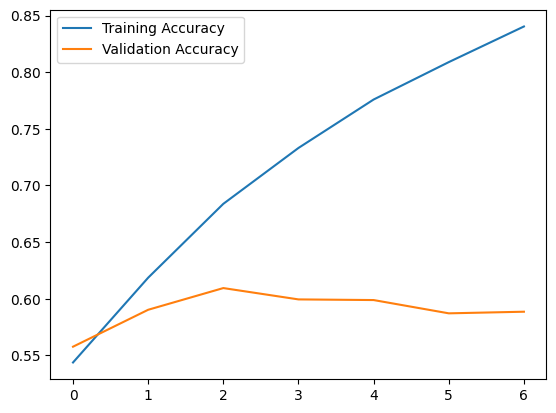

In [16]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Plot training history
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.show()